In [2]:
from pathlib import Path

import nshutils as nu
from jmp.lightning_datamodule import MPTrjAlexOMAT24DataModuleConfig

data_config = MPTrjAlexOMAT24DataModuleConfig.draft()
data_config.batch_size = 1
data_config.num_workers = 0
data_config.salex.local_path = Path("/storage/nima/salex-ocp/hf/")
data_config.omat24.local_path = Path("/storage/nima/omat24/hf/")

data_config.mptrj.enabled = False
data_config.salex.enabled = False
data_config.omat24.enabled = False

data_config.with_linear_reference_("mptrj-salex")
data_config = data_config.finalize()
nu.display(data_config)

In [44]:
from typing import Literal

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns


def plot_energy_histograms_plotly(
    data_dict,
    *,
    x_range=(-150, 150),
    nbins=None,
    opacity=0.75,
    title: str,
):
    """
    Create an interactive histogram plot using Plotly.

    Parameters:
    data_dict (dict): A dictionary where keys are labels and values are lists of energy data.
    x_range (tuple): The range for the x-axis (default: (-150, 150)).
    nbins (int): Number of bins for the histogram, or None to automatically determine the number of bins (default: None).
    opacity (float): Opacity of the histogram bars (default: 0.75).
    title (str): Title of the plot.

    Returns:
    plotly.graph_objects.Figure: The created figure object.
    """

    traces = []
    for label, energies in data_dict.items():
        trace = go.Histogram(
            x=energies,
            name=label,
            opacity=opacity,
            nbinsx=nbins,
            histnorm="probability",  # Use raw counts instead of density
        )
        traces.append(trace)

    layout = go.Layout(
        title=title,
        xaxis=dict(title="Energy", range=x_range),
        yaxis=dict(title="Count"),
        barmode="overlay",
        legend=dict(
            x=1,
            y=1,
            bgcolor="rgba(255, 255, 255, 0.5)",
            bordercolor="rgba(0, 0, 0, 0.1)",
        ),
        template="plotly_white",
    )

    fig = go.Figure(data=traces, layout=layout)

    fig.update_layout(
        font=dict(family="Arial", size=14),
        plot_bgcolor="rgba(240, 240, 240, 0.95)",
        hovermode="closest",
    )

    return fig


def plot_energy_histograms_seaborn(
    data_dict,
    *,
    x_range=(-150, 150),
    bins: int | Literal["auto"] = "auto",
    kde=False,
    title: str,
):
    """
    Create a histogram plot using Seaborn.

    Parameters:
    data_dict (dict): A dictionary where keys are labels and values are lists of energy data.
    x_range (tuple): The range for the x-axis (default: (-150, 150)).
    bins (int): Number of bins for the histogram, or "auto" to automatically determine the number of bins (default: "auto").
    kde (bool): Whether to show the kernel density estimate (default: False).
    title (str): Title of the plot.

    Returns:
    matplotlib.figure.Figure: The created figure object.
    """

    fig, ax = plt.subplots(figsize=(10, 6))

    for label, energies in data_dict.items():
        sns.histplot(energies, ax=ax, label=label, bins=bins, kde=kde)

    ax.set_xlim(x_range)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Energy", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.legend(fontsize=10)

    plt.tight_layout()
    return fig


def plot_both(
    data_dict,
    *,
    title: str,
    x_range=(-150, 150),
    nbins: int | Literal["auto"] = "auto",
    opacity=0.75,
):
    plot_energy_histograms_seaborn(
        data_dict,
        x_range=x_range,
        bins=nbins,
        title=title,
    ).show()
    plt.show()

    plot_energy_histograms_plotly(
        data_dict,
        x_range=x_range,
        nbins=None if nbins == "auto" else nbins,
        opacity=opacity,
        title=title,
    ).show()

In [3]:
import numpy as np
from jmp.lightning_datamodule import MPTrjAlexOMAT24DataModule
from tqdm.auto import tqdm


def get(name, num_samples: int = 10_000):
    data_config_ = data_config.model_copy()
    getattr(data_config_, name).enabled = True

    dm = MPTrjAlexOMAT24DataModule(data_config_)
    dm.prepare_data()
    dm.setup("fit")

    dl = dm.train_dataloader()

    values = []
    for i, batch in tqdm(enumerate(dl), total=num_samples):
        if i >= num_samples:
            break

        values.append(batch.y.cpu().numpy())

    values = np.concatenate(values, axis=0)
    return values


mptrj_energies = get("mptrj")
salex_energies = get("salex")
omat24_energies = get("omat24")

print(mptrj_energies.shape, salex_energies.shape, omat24_energies.shape)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000,) (10000,) (10000,)


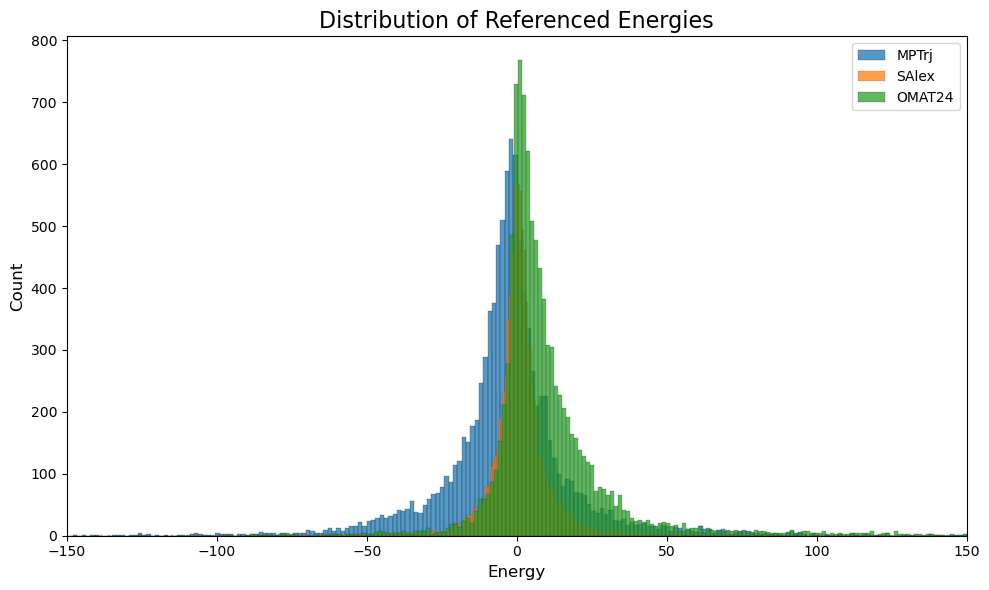

In [45]:
plot_both(
    {
        "MPTrj": mptrj_energies,
        "SAlex": salex_energies,
        "OMAT24": omat24_energies,
    },
    x_range=(-150, 150),
    title="Distribution of Referenced Energies",
)

In [8]:
def get_nolinref(name, num_samples: int = 10_000):
    data_config_ = data_config.model_copy()
    getattr(data_config_, name).enabled = True
    data_config_.reference = None

    dm = MPTrjAlexOMAT24DataModule(data_config_)
    dm.prepare_data()
    dm.setup("fit")

    dl = dm.train_dataloader()

    values = []
    for i, batch in tqdm(enumerate(dl), total=num_samples):
        if i >= num_samples:
            break

        values.append(batch.y.cpu().numpy())

    values = np.concatenate(values, axis=0)
    return values


mptrj_total_energies = get("mptrj")
salex_total_energies = get("salex")
omat24_total_energies = get("omat24")

print(
    mptrj_total_energies.shape, salex_total_energies.shape, omat24_total_energies.shape
)

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000,) (10000,) (10000,)


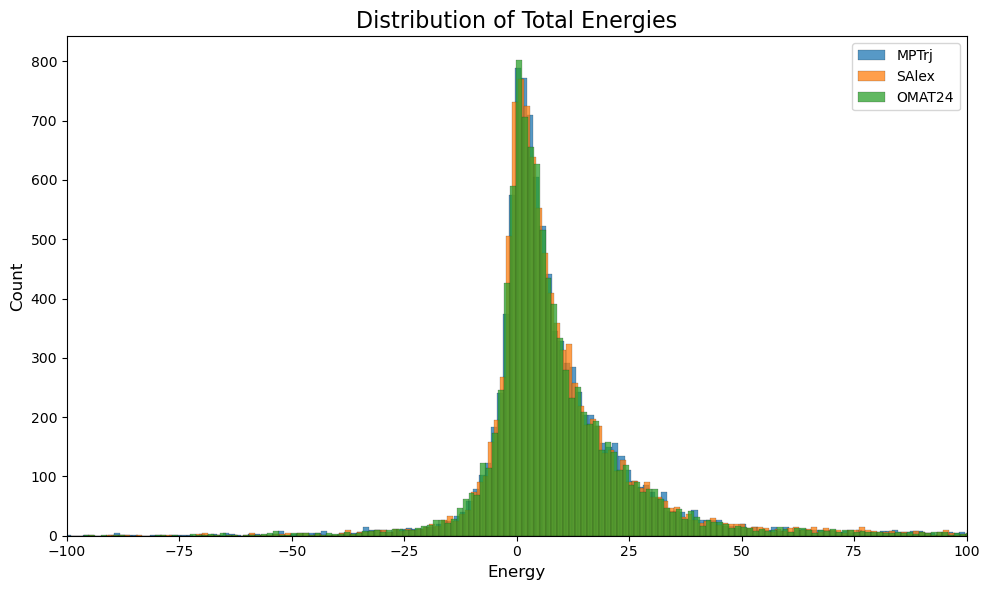

In [46]:
plot_both(
    {
        "MPTrj": mptrj_total_energies,
        "SAlex": salex_total_energies,
        "OMAT24": omat24_total_energies,
    },
    x_range=(-100, 100),
    title="Distribution of Total Energies",
)

In [10]:
def get_nolinref_peratom(name, num_samples: int = 10_000):
    data_config_ = data_config.model_copy()
    getattr(data_config_, name).enabled = True
    data_config_.reference = None

    dm = MPTrjAlexOMAT24DataModule(data_config_)
    dm.prepare_data()
    dm.setup("fit")

    dl = dm.train_dataloader()

    values = []
    for i, batch in tqdm(enumerate(dl), total=num_samples):
        if i >= num_samples:
            break

        values.append((batch.y / batch.natoms.float()).cpu().numpy())

    values = np.concatenate(values, axis=0)
    return values


mptrj_peratom_energies = get("mptrj")
salex_peratom_energies = get("salex")
omat24_peratom_energies = get("omat24")

print(
    mptrj_peratom_energies.shape,
    salex_peratom_energies.shape,
    omat24_peratom_energies.shape,
)

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000,) (10000,) (10000,)


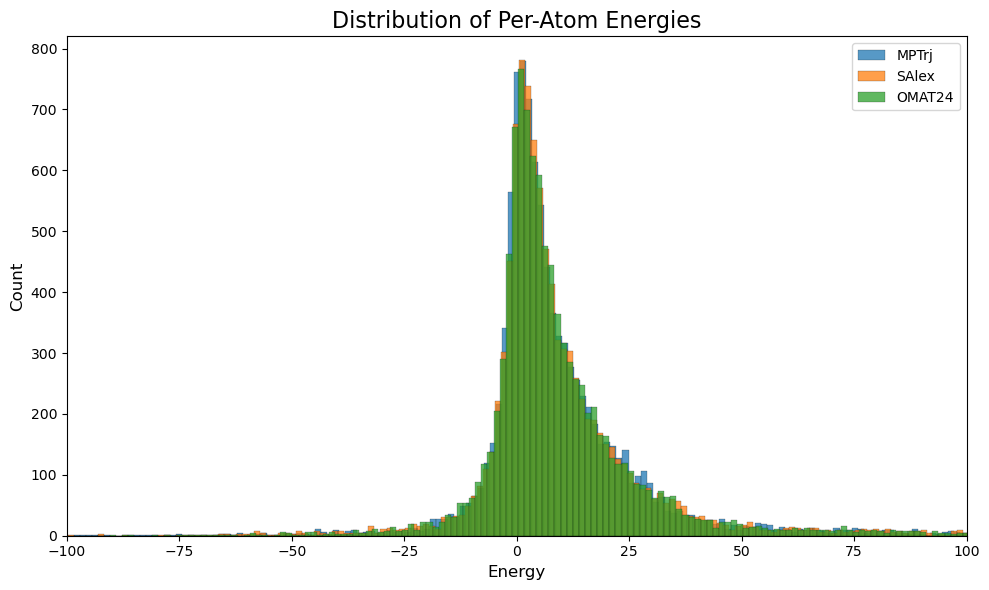

In [47]:
plot_both(
    {
        "MPTrj": mptrj_peratom_energies,
        "SAlex": salex_peratom_energies,
        "OMAT24": omat24_peratom_energies,
    },
    x_range=(-100, 100),
    title="Distribution of Per-Atom Energies",
)